---
title: 06 Line Linking
description: Rose Diagrams
authors:
  - name: Ryan E Lima
    orcid: 0000-0002-5352-7215
---

# Rose Diagrams 

A rose diagram is a circular histogram used to represent the frequency of data in various directional bins. In geology, it is particularly useful for visualizing orientations.

Rose diagrams are commonly employed in geology to:

1. **Visualize Lineaments:** Represent the orientation of faults, fractures, or structural features.
3. **Analyze Wind or Water Flow Patterns:** Determine prevailing directions of wind or currents from sedimentary structures.
4. **Study Joint Sets:** Analyze sets of joints or bedding plane orientations.
5. **Paleocurrent Analysis:** Determine ancient flow directions based on sedimentary structures.


## Steps to creating a Rose Diagram

_In simple terms_

You want calculate bearings for the linear data either the bearing of the whole line, or by dividing the line into segments at the verticies and calculating bearings of each of the line segments. Then you want to imagine a circle divided into slices like a pizza or a pie, and count how many lines fall into each slice making each slice shorter or taller based on the count. Arrange the slices in a circular pattern so the directions line up with their respective angles. 

1. **Understand the data**

**What are you trying to understand about your data?** For our purposes we want to understand more about the karst subsurface. We know that sink holes, caves, and other conduits can form in karst, and they typically form along faults, fractures, or joints where the weaknesses of the rock are exploited by water. So we are trying to understand the structure of the subsurface by looking at how the subsurface impacts the morphology at the surface. We also want to test weather automated or semi-automted lineament detection methods are useful or trustworthy, so we want to know how the detected lineaments match with the known faults and orientation is something useful to compare.

**What does our data look like?** Our mapped faults are polyline shapfiles, and our detected lineaments are also polyline shapefiles. They are made up of linear segments connected by verticies. ArcGIS Pro has a calculate geometry tool that allows you to calculate the bearing of a line or polyline. Should we calculate the bearing across the whole line or break the line into segments splitting each at its verticies and then calculate bearings? To answer this question we should look at what the calculate geometry tool does? 

**How calculate bearings works** The `Calculate Geometry Attributes` tool in ArcGIS Pro determines the bearing of the polyline using the direction of the straight line connecting the start and end points of the polyline. Therefore it does not calculate the average bearing along the line's path. It calculates a bearing representing a straight line segment from the start point to the end point, bearing is meared clockwise from a reference direction of north $0^{\circ}$. To calculate the average or dominant bearing you need to split the line at verticies and use a mathematical or statistical approach to average the bearings. So end-to-end bearings are more useful for regional trends.
   
3. **Grouping into Directional Bins**
4. **Counting Frequencies**
5. **Normalizing** (optional)
6. **Plotting on a circular grid**
7. **Orienting the Diagram**



 

## Create a rose diagram with synthetic data

In [ ]:
# Install required packages

In [1]:
# Load Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

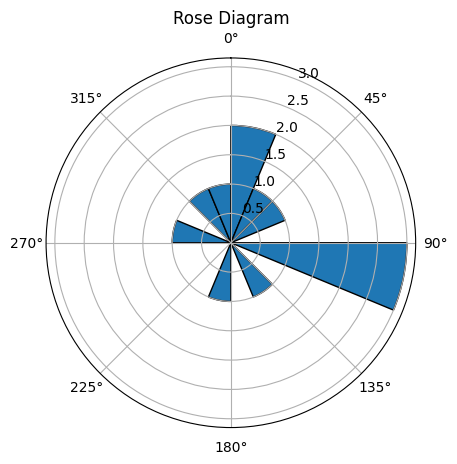

In [3]:
data = {'bearings': [10, 20, 30, 45, 90, 90, 100, 150, 180, 270, 330, 340]}
df = pd.DataFrame(data)

# Convert bearings to radians
radians = np.deg2rad(df['bearings'])

# Create bins (e.g., 22.5° intervals) (N, NNE, NE, ENE, E, ESE, SE, SSE, S, SSW, SW, WSW, W, WNW, NW, NNW)
num_bins = 16  # 360° divided by 22.5°
bin_edges = np.linspace(0, 2 * np.pi, num_bins + 1)
bin_counts, _ = np.histogram(radians, bins=bin_edges)

# Create the rose diagram
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
theta = bin_edges[:-1]  # Bin centers
width = 2 * np.pi / num_bins
ax.bar(theta, bin_counts, width=width, align='edge', edgecolor='black')

# Add labels and title
ax.set_theta_zero_location('N')  # North at the top
ax.set_theta_direction(-1)  # Clockwise direction
plt.title('Rose Diagram')
plt.show()

## Lets create some functions to make this whole process easier

In [30]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import LineString
import shapely.wkt

In [36]:
def preprocess_geometry(gdf):
    """
    Converts geometries to simple 2D LineString by dropping Z and M components.
    Handles both LineString and MultiLineString geometries.

    Args:
    - gdf: GeoDataFrame with geometries.

    Returns:
    - GeoDataFrame with 2D LineString geometries.
    """
    def to_2d(geometry):
        if geometry is None:
            return None
        elif geometry.geom_type == "LineString":
            # Convert LineString to 2D
            return LineString([(x, y) for x, y, *_ in geometry.coords])
        elif geometry.geom_type == "MultiLineString":
            # Convert MultiLineString to 2D by processing each sub-geometry
            lines = [
                LineString([(x, y) for x, y, *_ in line.coords])
                for line in geometry.geoms
            ]
            return shapely.geometry.MultiLineString(lines)
        else:
            raise ValueError(f"Unsupported geometry type: {geometry.geom_type}")

    # Apply the conversion to the geometry column
    gdf = gdf.copy()
    gdf['geometry'] = gdf['geometry'].apply(to_2d)
    return gdf

In [37]:
# Path to your shapefile
Contacts_path = r'C:\Users\rl587\GIS_Projects\ATUR_Lineaments_NAZ\LMSA\Mapped_Geology\Contacts\Contacts.zip'

# Load the shapefile
gdf = gpd.read_file(Contacts_path)

# Preprocess to ensure geometries are 2D LineString
gdf = preprocess_geometry(gdf)

In [38]:
def create_rose_diagram(dataframe, bearing_column, bin_width=22.5, bar_color='blue', title="Rose Diagram"):
    """
    Creates a rose diagram from a dataframe with directional data.

    Args:
    - dataframe: pandas DataFrame containing the bearing data.
    - bearing_column: str, name of the column containing bearings in degrees.
    - bin_width: int, width of each bin in degrees (default is 22.5).
    - bar_color: str, color of the bars.
    - title: str, title of the rose diagram.

    Returns:
    - A rose diagram plot.
    """
    bearings = dataframe[bearing_column]

    # Convert bearings to radians
    radians = np.deg2rad(bearings)

    # Calculate bins and counts
    num_bins = int(360 / bin_width)
    bin_edges = np.linspace(0, 2 * np.pi, num_bins + 1)
    bin_counts, _ = np.histogram(radians, bins=bin_edges)

    # Plot the rose diagram
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8, 8))
    theta = bin_edges[:-1]  # Bin start angles
    width = 2 * np.pi / num_bins  # Bin angular width
    bars = ax.bar(theta, bin_counts, width=width, color=bar_color, edgecolor='black', alpha=0.7)

    # Add directional annotations
    directions = [
        'N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE',
        'S', 'SSW', 'SW', 'WSW', 'W', 'WNW', 'NW', 'NNW'
    ]
    for i, direction in enumerate(directions):
        angle = np.deg2rad(i * 22.5)
        ax.text(angle, max(bin_counts) * 1.3, direction,  # Adjusted spacing with 1.3
                horizontalalignment='center', verticalalignment='center')

    ax.set_theta_zero_location('N')  # North at the top
    ax.set_theta_direction(-1)  # Clockwise

    # Set the title
    plt.title(title, fontsize=16)
    plt.show()


In [49]:
def plot_shapefile_with_rose_diagram(shapefile_path, bin_width=22.5, bar_color='blue', title="Shapefile and Rose Diagram"):
    """
    Plots a shapefile and its corresponding rose diagram side by side.

    Args:
    - shapefile_path: str, path to the shapefile.
    - bin_width: int, width of the bins in degrees for the rose diagram.
    - bar_color: str, color for the rose diagram bars.
    - title: str, title for the rose diagram plot.

    Returns:
    - A plot with the shapefile and its rose diagram side by side.
    """
    # Load shapefile and extract the dataframe and bearing column
    dataframe, bearing_column = load_shapefile_to_dataframe(shapefile_path)

    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    # Plot the shapefile
    gdf = gpd.read_file(shapefile_path)
    gdf.plot(ax=axes[0], color=bar_color, linewidth=1)
    axes[0].set_title('Shapefile Plot')
    axes[0].axis('off')

    # Create the rose diagram
    bearings = dataframe[bearing_column]
    radians = np.deg2rad(bearings)
    num_bins = int(360 / bin_width)
    bin_edges = np.linspace(0, 2 * np.pi, num_bins + 1)
    bin_counts, _ = np.histogram(radians, bins=bin_edges)

    ax = plt.subplot(122, projection='polar')
    theta = bin_edges[:-1]  # Bin start angles
    width = 2 * np.pi / num_bins  # Bin angular width
    ax.bar(theta, bin_counts, width=width, color=bar_color, edgecolor='black', alpha=0.7)

    # Add directional annotations
    directions = [
        'N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE',
        'S', 'SSW', 'SW', 'WSW', 'W', 'WNW', 'NW', 'NNW'
    ]
    for i, direction in enumerate(directions):
        angle = np.deg2rad(i * 22.5)
        ax.text(angle, max(bin_counts) * 1.3, direction,
                horizontalalignment='center', verticalalignment='center')

    ax.set_theta_zero_location('N')  # North at the top
    ax.set_theta_direction(-1)  # Clockwise

    # Remove the external box frame
    ax.spines['polar'].set_visible(False)

    ax.set_title(title)
    plt.tight_layout()
    plt.show()

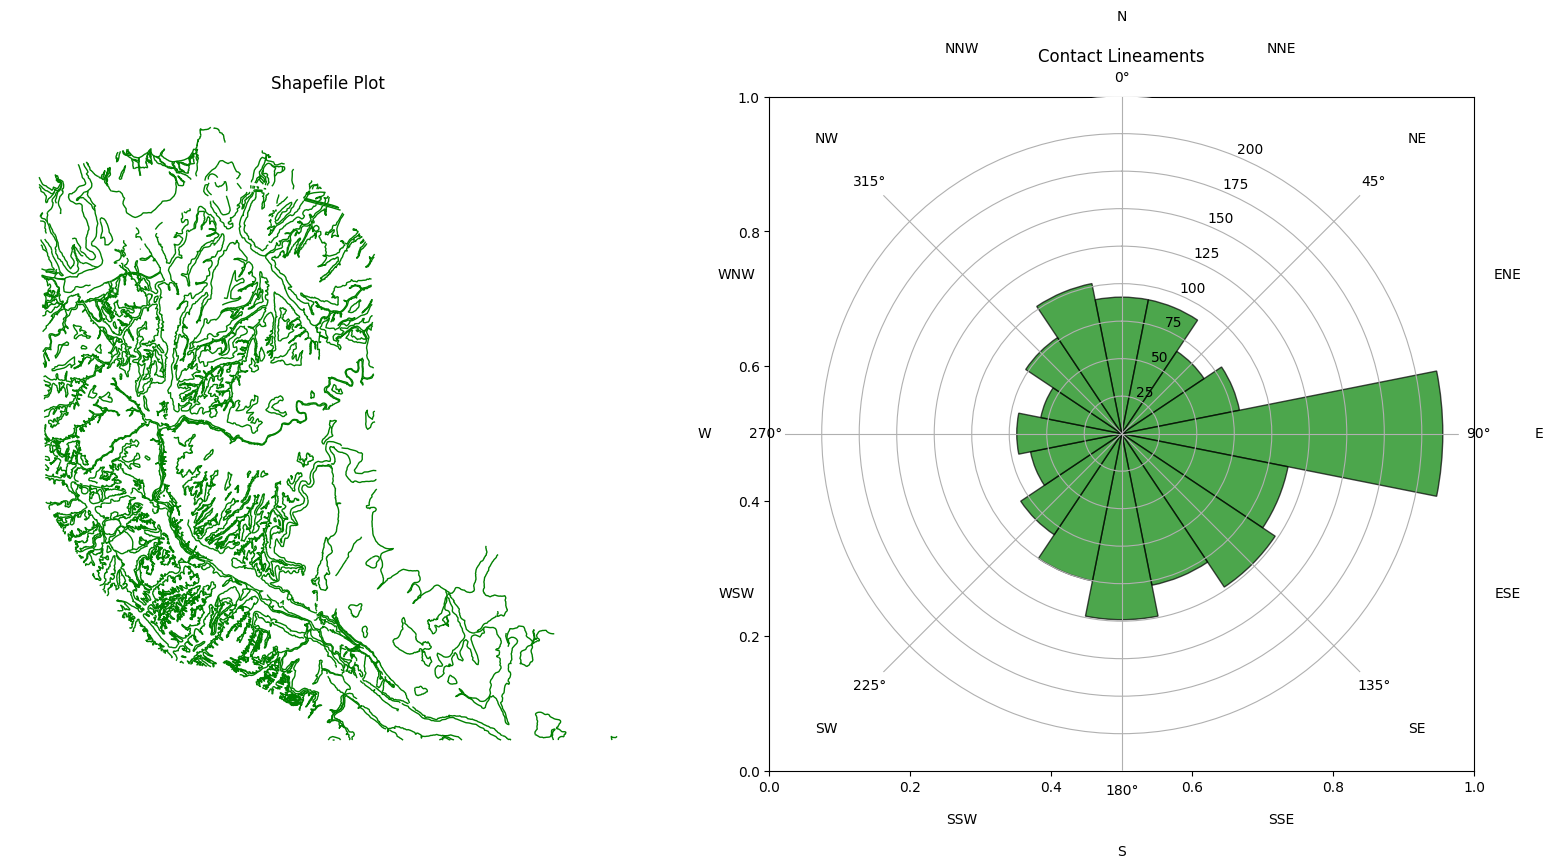

In [50]:
Contacts_path = r'C:\Users\rl587\GIS_Projects\ATUR_Lineaments_NAZ\LMSA\Mapped_Geology\Contacts\Contacts.zip'

# Create a rose diagram with a custom title
df, bearing_column = load_shapefile_to_dataframe(Contacts_path)
#create_rose_diagram(df, bearing_column=bearing_column, bar_color='green', title="Contact Orientation Rose Diagram")

# Plot shapefile with rose diagram and custom title
plot_shapefile_with_rose_diagram(Contacts_path, bar_color='green', title="Contact Lineaments")


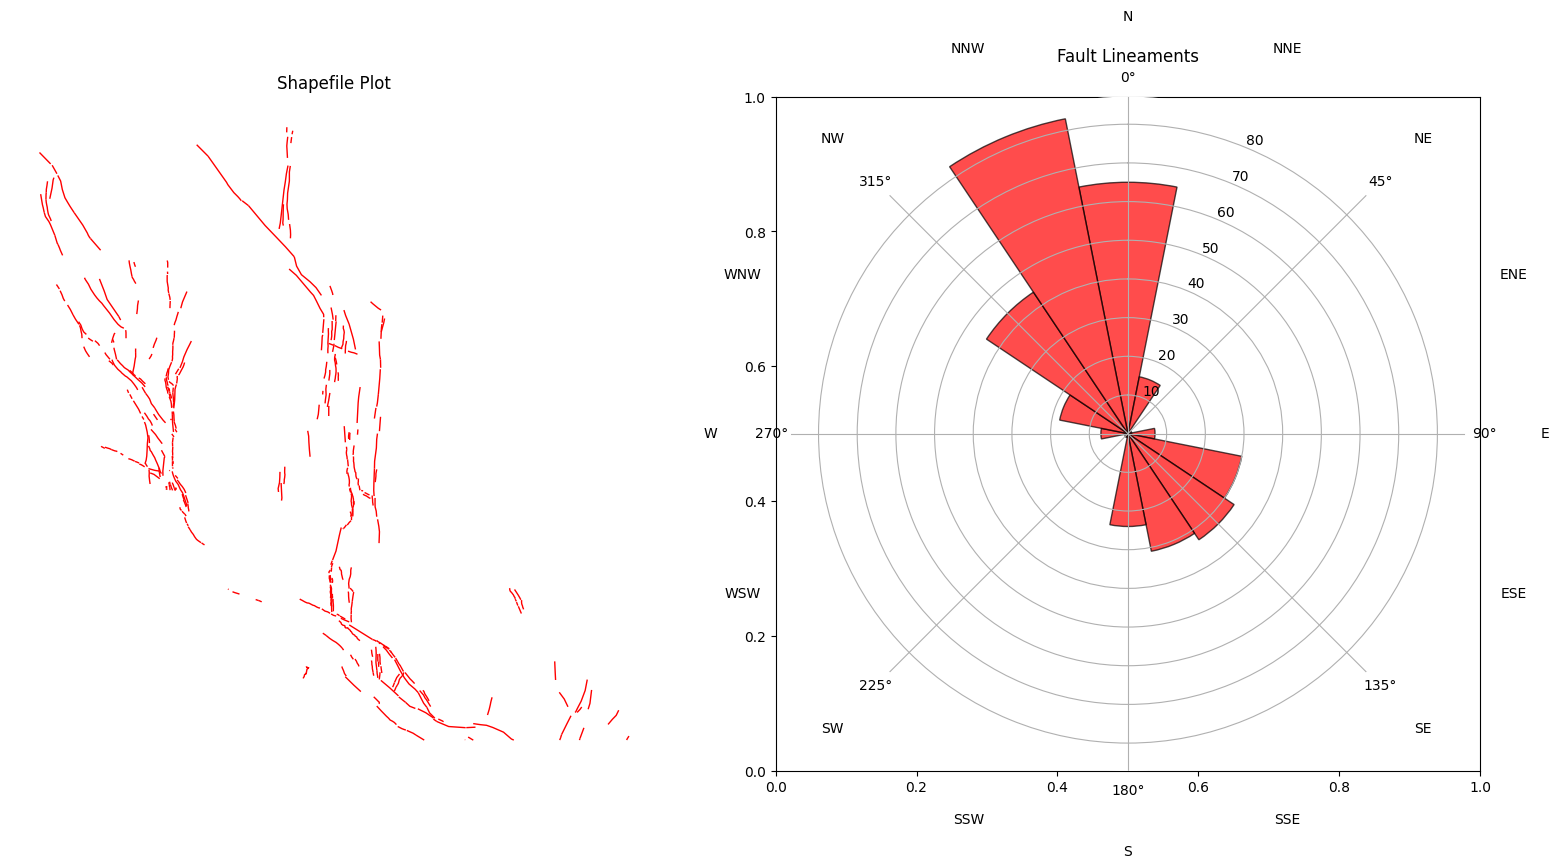

In [51]:
Faults_path = r'C:\Users\rl587\GIS_Projects\ATUR_Lineaments_NAZ\LMSA\Mapped_Geology\Faults\Faults.zip'

# Create a rose diagram with a custom title
df, bearing_column = load_shapefile_to_dataframe(Faults_path)
#create_rose_diagram(df, bearing_column=bearing_column, bin_width=10, bar_color='red', title="Fault Orientation Rose Diagram")

# Plot shapefile with rose diagram
plot_shapefile_with_rose_diagram(Faults_path, bin_width=22.5, bar_color='red',  title="Fault Lineaments")


C:\Users\rl587\AppData\Local\anaconda3\envs\ATUR-KARST\lib\site-packages\pyogrio\raw.py:198: UserWarning: Measured (M) geometry types are not supported. Original type 'Measured 3D LineString' is converted to 'LineString Z'
  return ogr_read(
C:\Users\rl587\AppData\Local\anaconda3\envs\ATUR-KARST\lib\site-packages\pyogrio\raw.py:198: UserWarning: Measured (M) geometry types are not supported. Original type 'Measured 3D LineString' is converted to 'LineString Z'
  return ogr_read(
C:\Users\rl587\AppData\Local\anaconda3\envs\ATUR-KARST\lib\site-packages\pyogrio\raw.py:198: UserWarning: Measured (M) geometry types are not supported. Original type 'Measured 3D LineString' is converted to 'LineString Z'
  return ogr_read(


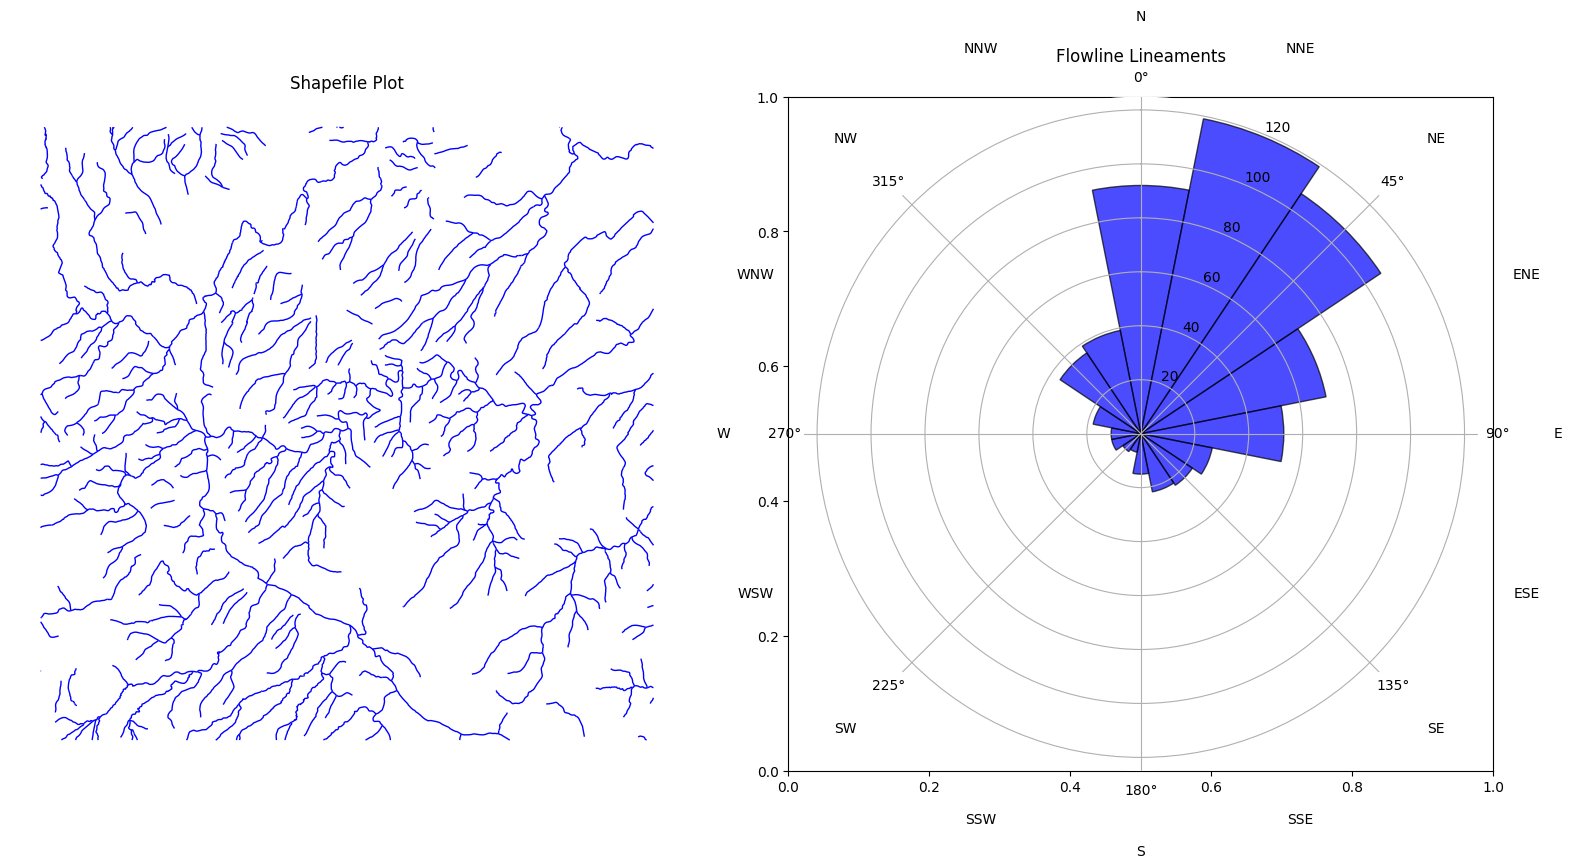

In [52]:
Flowlines_path = r'C:\Users\rl587\GIS_Projects\ATUR_Lineaments_NAZ\LMSA\Mapped_Geology\NHD_flowlines\NHD_flowlines.zip'

# Create a rose diagram with a custom title
df, bearing_column = load_shapefile_to_dataframe(Flowlines_path)
#create_rose_diagram(df, bearing_column=bearing_column, bin_width=10, bar_color='blue', title="Flowline Orientation Rose Diagram")

# Plot shapefile with rose diagram
plot_shapefile_with_rose_diagram(Flowlines_path, bin_width=22.5, bar_color='blue', title = "Flowline Lineaments")